In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os
import resnet_model
print(tf.__version__)

2.1.0


In [2]:
#train_image_path = glob.glob("./data/data_mag/train/*/*.PNG")
train_image_path = glob.glob("./data/dc_3000/train/*/*.jpg")
len(train_image_path)

3000

In [3]:
def load_preprocess_image(path,label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,[256,256])

    # 数据增强 -- 随机裁剪
    #image = tf.image.random_crop(image,[256,256,3])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    # image = tf.image.random_brightness(image,0.5)
    # image = tf.image.random_contrast(image,0.3 ,1)

    image = tf.cast(image,tf.float32)
    image = image/255
    label = tf.reshape(label,[1])
    return image, label

In [4]:
def load_preprocess_test_image(path,label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,[256,256])
    image = tf.cast(image,tf.float32)
    image = image/255
    label = tf.reshape(label,[1])
    return image, label

### Make traindata && label

In [5]:
#train_image_label = [int((p.split("\\")[1]))for p in train_image_path]    #only label
#train_image_label = [tf.one_hot(int((p.split("\\")[1])),3,on_value=1,off_value=None,axis=0)for p in train_image_path]  #one-hot
train_image_label = [int((p.split("\\")[1]))for p in train_image_path]  #label

print(train_image_label)


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [6]:
#train_image_label = tf.float32(train_image_label)
train_image_label = tf.cast(train_image_label,tf.float32)
print(train_image_label[0],train_image_label[800],train_image_label[1449])

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(2.0, shape=(), dtype=float32)


In [7]:
train_image_ds = tf.data.Dataset.from_tensor_slices((train_image_path,train_image_label))
train_image_ds

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.float32)>

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_image_ds = train_image_ds.map(load_preprocess_image,num_parallel_calls = AUTOTUNE)

tf.Tensor([1.], shape=(1,), dtype=float32)


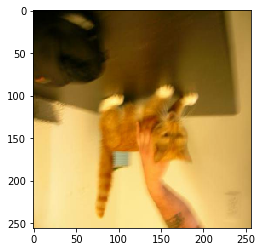

In [9]:
for img,label in train_image_ds.take(1):
    print(label)
    plt.imshow(img)

In [10]:
train_image_ds

<ParallelMapDataset shapes: ((256, 256, 3), (1,)), types: (tf.float32, tf.float32)>

In [11]:
BATCH_SIZE = 16
train_count = len(train_image_path)
train_image_ds = train_image_ds.shuffle(train_count).batch(BATCH_SIZE).prefetch(AUTOTUNE) # prefetch用来加速的

In [12]:
test_image_path = glob.glob("./data/dc_3000/val/*/*.jpg") ## 不好的代码规范
# test_image_label = [tf.one_hot(int((p.split("\\")[1])),3,on_value=1,off_value=None,axis=0)for p in test_image_path]

test_image_label = [int((p.split("\\")[1]))for p in test_image_path]

test_image_ds = tf.data.Dataset.from_tensor_slices((test_image_path,test_image_label))
test_image_ds = test_image_ds.map(load_preprocess_test_image,num_parallel_calls = AUTOTUNE)
test_image_ds = test_image_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_image_label = tf.cast(test_image_label,tf.float32)

In [13]:
test_image_label

<tf.Tensor: shape=(1300,), dtype=float32, numpy=array([1., 1., 1., ..., 3., 3., 3.], dtype=float32)>

### Model

In [14]:
model = keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), input_shape=(256, 256, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
]) 

In [15]:
# import resnet_model
# model = resnet_model.resnet50(
#         num_classes = 3,
#         use_l2_regularizer = True) 
# #[244,244]

In [16]:
# import resnet_model2
# model = resnet_model2.ResNet(34)

### test

In [17]:
imgs, labels = next(iter(train_image_ds))
imgs

<tf.Tensor: shape=(16, 256, 256, 3), dtype=float32, numpy=
array([[[[5.49019612e-02, 8.20229650e-02, 5.55619188e-02],
         [6.04856014e-02, 8.75747055e-02, 6.12093471e-02],
         [6.12821691e-02, 8.81050825e-02, 6.25382960e-02],
         ...,
         [5.39174259e-01, 3.09237123e-01, 3.31196398e-01],
         [5.38049817e-01, 3.24954271e-01, 3.48815054e-01],
         [5.76371014e-01, 3.73705566e-01, 4.19540167e-01]],

        [[5.86703420e-02, 8.31667110e-02, 6.65594339e-02],
         [6.34554103e-02, 8.78483206e-02, 7.17427880e-02],
         [6.45721406e-02, 8.81015584e-02, 7.61836618e-02],
         ...,
         [5.68580985e-01, 3.27059805e-01, 3.65733445e-01],
         [5.15031576e-01, 3.00315678e-01, 3.30472767e-01],
         [5.14981747e-01, 3.24555874e-01, 3.58318120e-01]],

        [[6.27451017e-02, 8.62745121e-02, 7.76897967e-02],
         [6.48573041e-02, 8.83867145e-02, 7.98813477e-02],
         [6.81295991e-02, 9.16590095e-02, 8.38158727e-02],
         ...,
         [

In [18]:
pred = model.build(imgs)
pred = model(imgs)
print(pred.shape)
print('pred',pred[0].numpy(),print(pred[0]))
print('labels',labels[0].numpy(),print(labels[0]))

(16, 1)
tf.Tensor([-0.08770836], shape=(1,), dtype=float32)
pred [-0.08770836] None
tf.Tensor([1.], shape=(1,), dtype=float32)
labels [1.] None


In [19]:
print(np.array([p[0].numpy() for p in tf.cast(pred>0,tf.int32)]))
print(np.array([l[0].numpy() for l in labels]))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1. 3. 1. 3. 1. 1. 3. 3. 3. 2. 2. 2. 2. 3. 2. 3.]


### train

In [20]:
ls = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()
#optimizer = tf.keras.optimizers.SGD()

In [21]:
# 一些用于记录中间值的metrics模块
epoch_loss_avg = tf.keras.metrics.Mean("train_loss")
train_accuracy = tf.keras.metrics.Accuracy()

epoch_loss_avg_test = tf.keras.metrics.Mean("test_loss")
test_accuracy = tf.keras.metrics.Accuracy()

In [22]:
# 每一步训练
def train_step(model, images, labels):
    with tf.GradientTape() as t:
        pred = model(images)
        loss_step = tf.keras.losses.BinaryCrossentropy(from_logits=True)(labels, pred)
    grads = t.gradient(loss_step, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    epoch_loss_avg(loss_step)
    train_accuracy(labels,tf.cast(pred>0,tf.int32))
    return pred

In [23]:
# 每一次测试
def test_step(model, images, labels):
    pred = model(images)
    loss_step = tf.keras.losses.BinaryCrossentropy(from_logits=True)(labels, pred)  # 这里参数的意思是没有激活
    epoch_loss_avg_test(loss_step)
    test_accuracy(labels,tf.cast(pred>0,tf.int32))
    return pred

In [24]:
# 定义四个个空列表进行每一个epoch的记录
train_loss_result = []
train_acc_result = []
test_loss_result = []
test_acc_result = []
num_epochs = 1000

In [ ]:
# 训练
for epoch in range(num_epochs):
    # 训练
    for imgs_,labels_ in train_image_ds:
        train_step(model, imgs_, labels_)
        print(".",end="") #仅仅是让我看到他在训练
        break
    print()

    #  记录每次epoch 的结果
    train_loss_result.append(epoch_loss_avg.result())
    train_acc_result.append(train_accuracy.result())
    
    
    #  测试
    for imgs_,labels_ in test_image_ds:
        pred_ = test_step(model, imgs_, labels_)
        print("/",end="") #仅仅是让我看到他在测试
        print(labels_,pred_)

        break
    print()

    #  记录每次epoch 的结果
    test_loss_result.append(epoch_loss_avg_test.result())
    test_acc_result.append(test_accuracy.result())

    
    # 打印出来每个训练epoch的损失和精确值
    print(f'Train Epoch:{epoch+1};loss{epoch_loss_avg.result():.3f},accuracy:{train_accuracy.result():.3f},test_loss:{epoch_loss_avg_test.result():.3f},test_accuracy:{test_accuracy.result():.3f};')

    #  loss_avg 和 train_accuracy清零
    epoch_loss_avg.reset_states()
    train_accuracy.reset_states()
    epoch_loss_avg_test.reset_states()
    test_accuracy.reset_states()

.
/tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(16, 1), dtype=int32) tf.Tensor(
[[0.130367  ]
 [0.16082366]
 [0.11219446]
 [0.13860652]
 [0.14166643]
 [0.12511905]
 [0.17758778]
 [0.14856786]
 [0.13213502]
 [0.14196661]
 [0.14166582]
 [0.14136684]
 [0.16771944]
 [0.16223237]
 [0.12604086]
 [0.10527807]], shape=(16, 1), dtype=float32)

Train Epoch:1;loss0.775,accuracy:0.000,test_loss:0.625,test_accuracy:1.000;
.
/tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(16, 1), dtype=int32) tf.Tensor(
[[0.2982913 ]
 [0.36445507]
 [0.26352158]
 [0.31842813]
 [0.32239166]
 [0.27635026]
 [0.41438895]
 [0.34780967]
 [0.29780385]
 [0.32607654]
 [0.32772788]
 [0.32669473]
 [0.37708563]
 [0.3671771 ]
 [0.286249  ]
 [0.24259028]], shape=(16, 1), dtype=float32)

Train Epoch:2;loss0.468,accuracy:0.375,test_loss:0.545,test_accuracy:1.000;
.
/tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
